# 자전거 대여 데이터

- 2011년부터 2012년까지 2년간의 자전거 대여 데이터
- 캐피털 바이크셰어 회사가 공개한 운행 기록에 다양한 외부 소스에서 얻은 당시 날씨 정보를 조합
- 한 시간 간격으로 기록됨

- 훈련 데이터 : 매달 1일부터 19일까지의 기록
- 테스트 데이터 : 매달 20일부터 월말까지의 기록

- 피처
    - datetime : 기록 일시(1시간 간격)
    - season : 계절 (1 : 봄(1분기), 2 : 여름(2분기), 3 : 가을(3분기), 4 : 겨울(4분기))
        - 공식 문서에는 계절로 설명하고 있지만 실제로는 분기로 나누어져 있음
    - holiday : 공휴일 여부 (0 : 공휴일 아님, 1 : 공휴일)
    - workingday : 근무일 여부(0 : 근무일 아님, 1 : 근무일)
        - 주말과 공휴일이 아니면 근무일이라고 간주
    - weather : 날씨 (1 : 맑음, 2 : 옅은 안개, 약간 흐림, 3 : 약간의 눈, 약간의 비와 천둥 번개, 흐림, 4 : 폭우와 천둥 번개, 눈과 짙은 안개)
        - 숫자가 클수록 날씨가 안 좋음
    - temp : 실제 온도
    - atemp : 체감 온도
    - humidity : 상대 습도
    - windspeed : 풍속
    - casual : 등록되지 않은 사용자(비회원) 수
    - registered : 등록된 사용자(회원) 수
    - count : 자전거 대여 수량
    
- 종속변수 : count
    
- 평가지표 : RMSLE(Root Mean Squared Logarithmic Error)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
# pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer # 군집시각화

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap # 그래프 색깔 설정
import statsmodels.api as sm # statsmodels = 통계모델 의 여러가지 통계치를 보고 독립변수를 체크하려고씀

# 데이터 체크 
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor # 다중공선성체크 


# 전처리 도구 모음
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures #다항회귀
from sklearn.preprocessing import RobustScaler # 이상치에 영향을 덜 받게 하려고 씀 

# 데이터 고르기
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

# 평가지표
from sklearn.metrics import mean_absolute_error # 평균 절댓값 오차(정확도를 쓸수없어서 대신에 쓰는것임)
from sklearn.metrics import mean_squared_error # 제곱해서 평균낸 잔차
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score # 이진모델분류에서 많이 사용
from sklearn.metrics import silhouette_score # 실루엣 계수 계산

# 알고리즘
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA # 주성분분석
from sklearn.svm import SVC # 서포터 벡터머신 (분류할꺼야)

# 선형회귀(예측)
from sklearn.linear_model import LinearRegression # 선형회귀
from sklearn.linear_model import Ridge, Lasso # 릿지 라쏘
from sklearn.linear_model import SGDClassifier # 선형모델에 경사하강법을 많이 적용한다

# 트리 기반
from sklearn.tree import DecisionTreeClassifier, plot_tree #트리기반의 모델들

# 앙상블
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

# 로지스틱 회귀(분류)
from sklearn.linear_model import LogisticRegression

# 군집
from sklearn.cluster import KMeans, DBSCAN

# 파이프라인
from sklearn.pipeline import make_pipeline, Pipeline

# 경고메세지 무시
# import warnings 
# warnings.filterwarnings("ignore") # 경고 메세지 나오는거 무시

In [2]:
def rmsle(y_true, y_pred):
    '''
    실제 타깃값과 예측값을 인수로 전달하면 RMSLE 수치를 반환하는 함수
    '''
    # 로그변환 후 결측값을 0으로 변환
    log_true = np.nan_to_num(np.log(y_true + 1))
    log_pred = np.nan_to_num(np.log(y_pred + 1))
    
    # RMSLE 계산
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    
    return output

In [2]:
train_df = pd.read_csv("./data/bike/train.csv")
test_df = pd.read_csv("./data/bike/test.csv")
submission_df = pd.read_csv("./data/bike/sampleSubmission.csv")

In [3]:
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
test_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [5]:
submission_df.head() # 여기에 count 를 넣는다

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


### 시계열 데이터이므로 훈련과 테스트 세트의 구별점을 알아야한다

In [6]:
train_df.shape , test_df.shape

((10886, 12), (6493, 9))

In [7]:
train_df.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

In [8]:
test_df.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
dtype: object

In [9]:
train_df.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [10]:
test_df.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

- 일단 둘다 결측치 없음

In [11]:
train_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [12]:
test_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600


- 테스트 데이터에서는 casual, registered 컬럼이 따로 없음
- 컬럼 제거해야겠는디 일단 상관계수 찍고 삭제하자

In [13]:
train_df.corr(numeric_only=True)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.096758,0.164011,0.163439
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,-0.005393
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,0.011594
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,-0.128655
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369
casual,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414
registered,0.164011,-0.020956,0.119460,-0.109340,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948


- 오잉? registered 와 count 의 상관계수가 0.970948 로 엄청 높음...
- casual 이것도 0.690414

## 없애고 상관계수 찍기

In [14]:
clean_train_df = train_df.drop(["casual","registered"], axis = 1)

In [15]:
clean_train_df.corr(numeric_only=True)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.163439
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,-0.005393
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,0.011594
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.128655
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.394454
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.389784
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.317371
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.101369
count,0.163439,-0.005393,0.011594,-0.128655,0.394454,0.389784,-0.317371,0.101369,1.000000


- 일단 상관계수 높아도 test 데이터에는 없으니까 컬럼에서 제거하는게 맞다고 봄

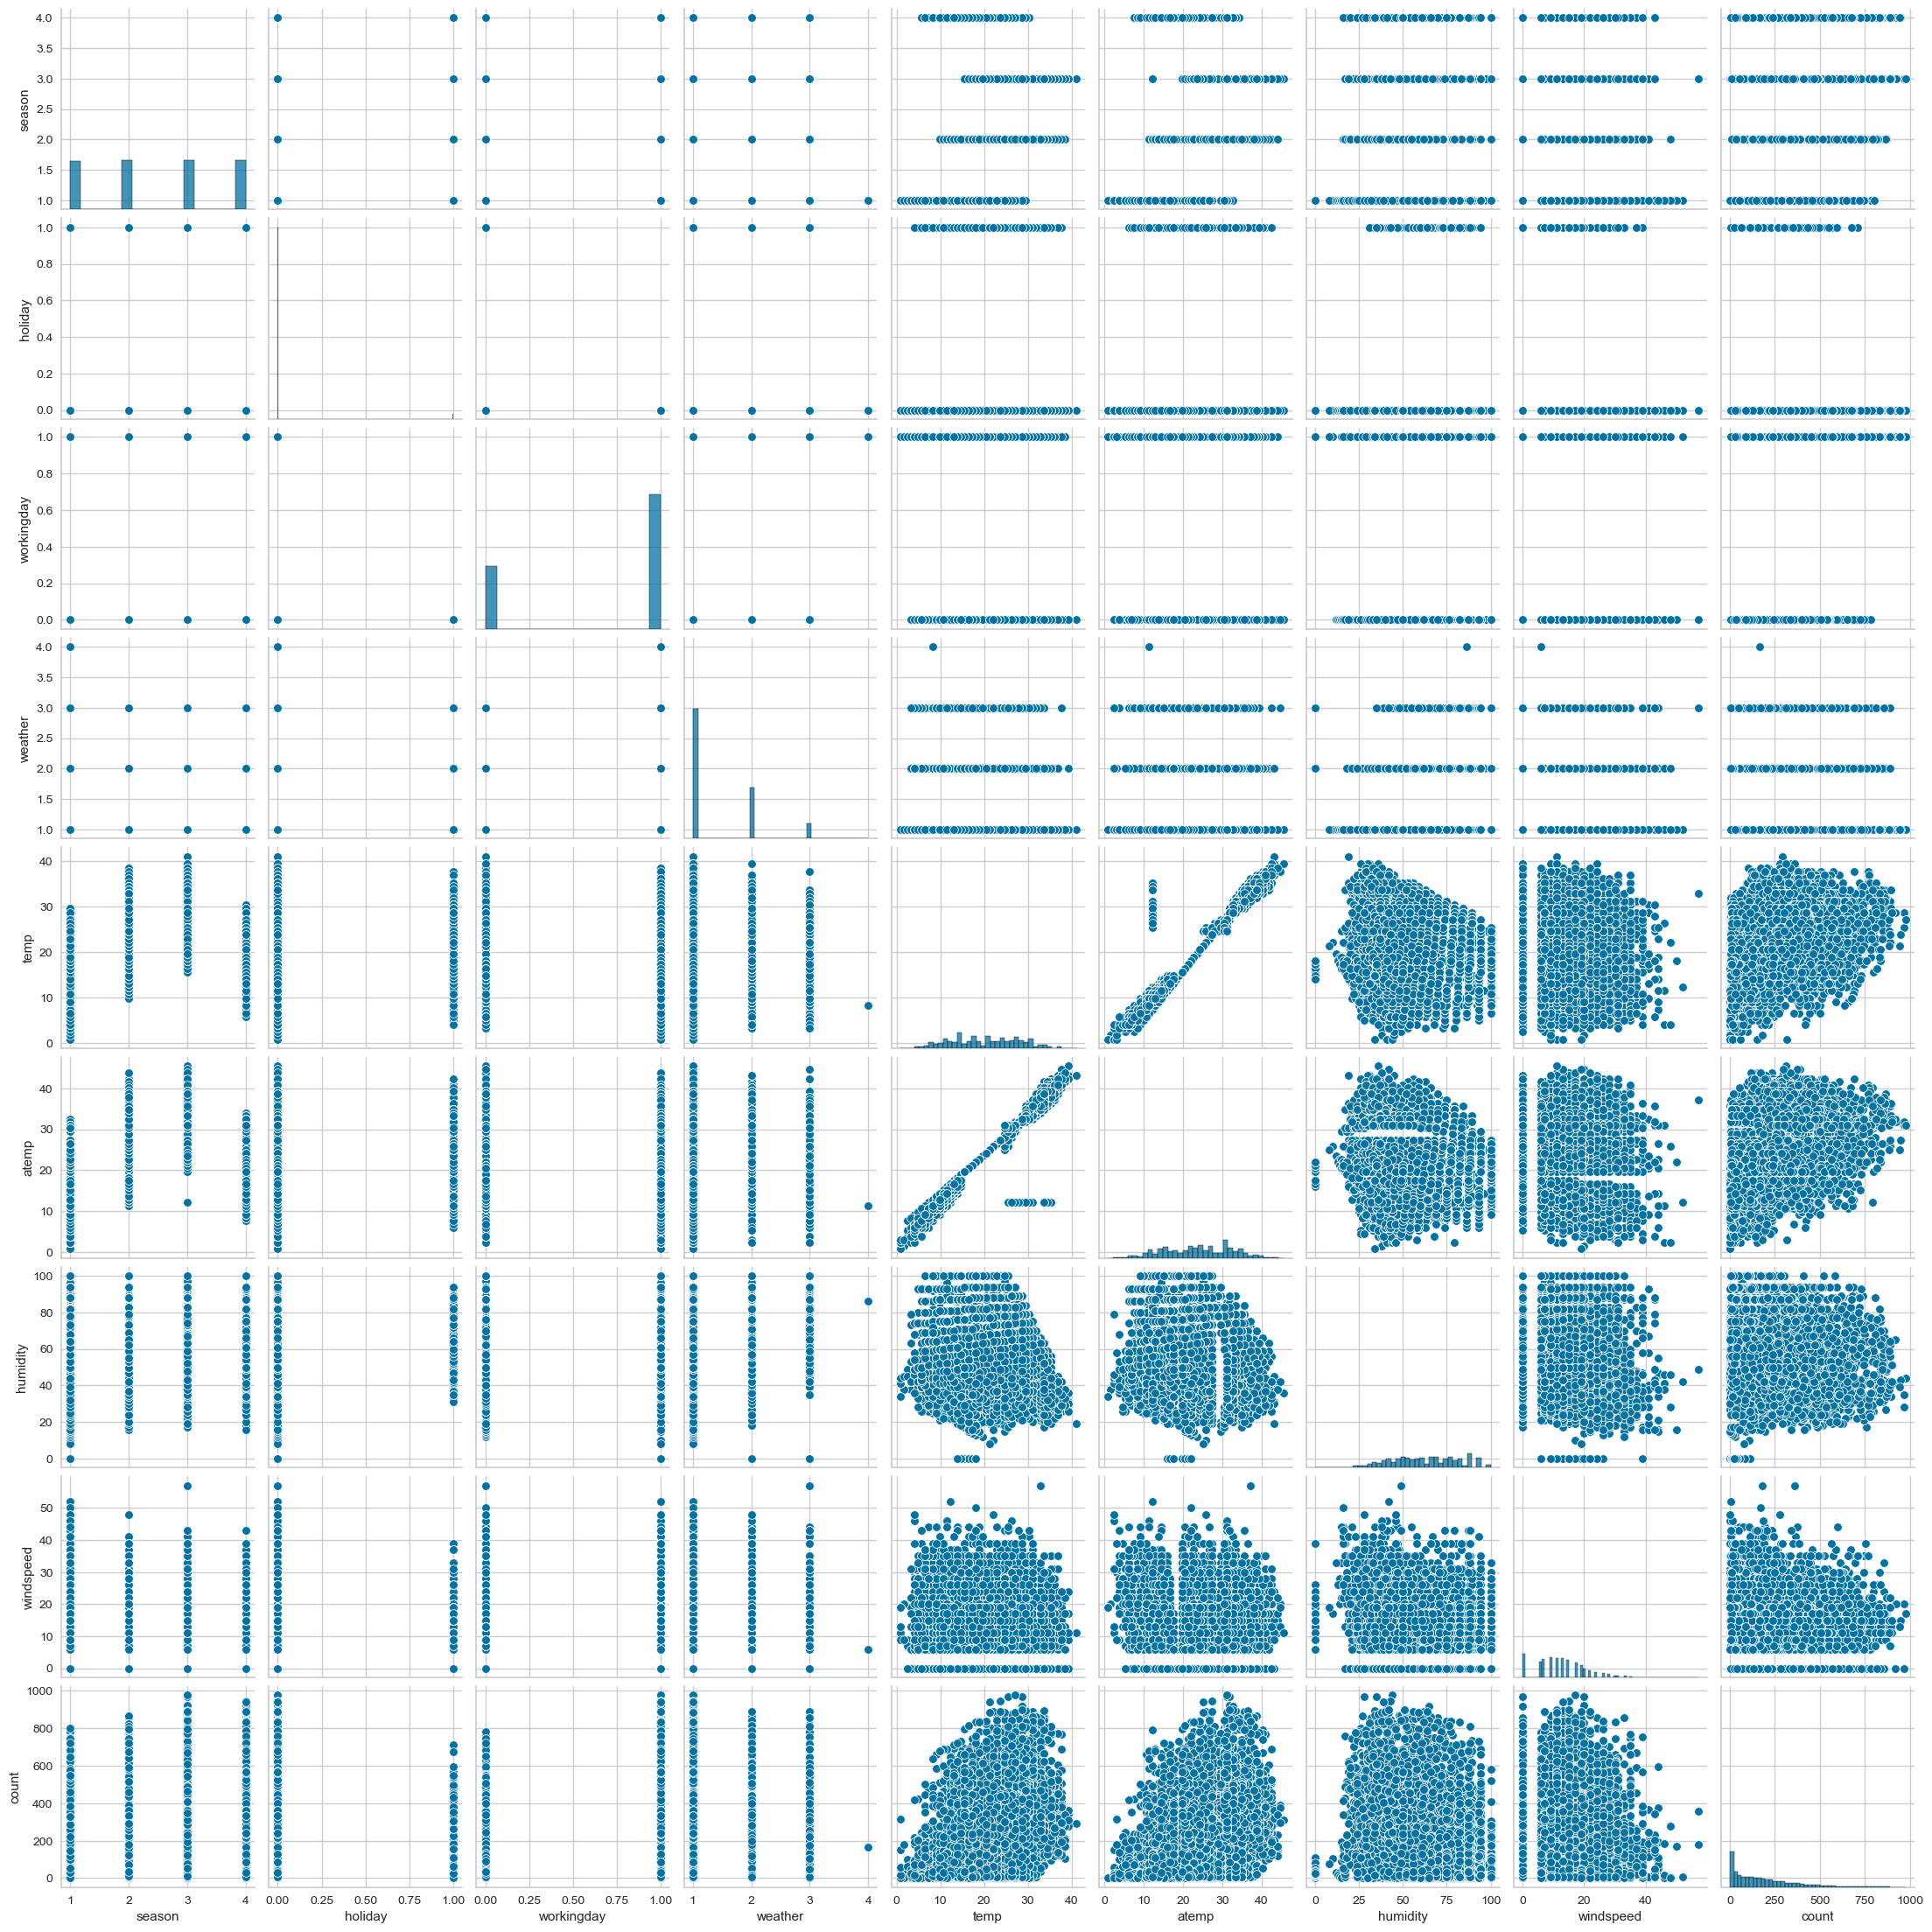

In [16]:
sns.pairplot(clean_train_df)
plt.show()

In [17]:
# train 이랑 test 데이터의 독립변수들 비교 하고 싶은데 
# 어떻게 하면 효율적으로 비교할수있냐...

- 체감온도와 실제온도 완전 선형관계 아니냐~~
- 온도가 따듯해질수록 사용자수가 늘어난다는 걸... 알수있나...?
- 풍속이 낮을수록 사용자수가 늘어난다

## 이거 월별,월별, 일별로 나눠서 파생변수 만들어줘야함

In [18]:
clean_train_df["datetime"] = pd.to_datetime(clean_train_df["datetime"])

In [19]:
clean_train_df["year"] = clean_train_df["datetime"].dt.year
clean_train_df["month"] = clean_train_df["datetime"].dt.month
clean_train_df["day"] = clean_train_df["datetime"].dt.day
clean_train_df["time"] = clean_train_df["datetime"].dt.time

In [20]:
clean_train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,time
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,00:00:00
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,01:00:00
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,02:00:00
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,1,03:00:00
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,1,04:00:00


- 이렇게하면 datetime 없애도 되것죵?

In [21]:
clean_train_df = clean_train_df.drop("datetime", axis=1)

In [22]:
clean_train_df

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,time
0,1,0,0,1,9.84,14.395,81,0.0000,16,2011,1,1,00:00:00
1,1,0,0,1,9.02,13.635,80,0.0000,40,2011,1,1,01:00:00
2,1,0,0,1,9.02,13.635,80,0.0000,32,2011,1,1,02:00:00
3,1,0,0,1,9.84,14.395,75,0.0000,13,2011,1,1,03:00:00
4,1,0,0,1,9.84,14.395,75,0.0000,1,2011,1,1,04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,19.695,50,26.0027,336,2012,12,19,19:00:00
10882,4,0,1,1,14.76,17.425,57,15.0013,241,2012,12,19,20:00:00
10883,4,0,1,1,13.94,15.910,61,15.0013,168,2012,12,19,21:00:00
10884,4,0,1,1,13.94,17.425,61,6.0032,129,2012,12,19,22:00:00


In [23]:
## 연도별 평균
clean_train_df.groupby("year").mean(numeric_only=True)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,month,day
year,,,,,,,,,,,
2011,2.511988,0.026558,0.682036,1.426411,19.751988,23.157086,63.405017,12.924144,144.223349,6.538547,9.982663
2012,2.501281,0.030564,0.679722,1.410505,20.706051,24.149254,60.379575,12.675605,238.560944,6.504575,10.002379


- 사용자가 2011년보다 2012년에 늘었구나~

In [24]:
## 월별 평균
month_mean_df = clean_train_df.groupby("month").mean(numeric_only=True)
month_mean_df

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,day
month,,,,,,,,,,,
1,1.0,0.080317,0.622172,1.400452,9.840000,12.077579,55.911765,14.582959,90.366516,2011.512443,9.916290
2,1.0,0.000000,0.708102,1.458380,11.798535,14.532608,56.296337,13.963707,110.003330,2011.504994,10.012209
3,1.0,0.000000,0.710322,1.413984,15.902175,19.017220,56.678135,15.363249,148.169811,2011.504994,9.976693
4,2.0,0.052805,0.656766,1.432343,18.718372,22.305891,55.697470,15.581090,184.160616,2011.499450,10.006601
5,2.0,0.000000,0.736842,1.527412,22.674079,26.632374,68.084430,12.293956,219.459430,2011.500000,10.000000
6,2.0,0.000000,0.684211,1.309211,27.064496,30.988750,58.759868,12.348930,242.031798,2011.500000,10.000000
7,3.0,0.052632,0.657895,1.255482,30.841711,34.900395,58.402412,11.019928,235.325658,2011.500000,10.000000
8,3.0,0.000000,0.736842,1.351974,29.736689,33.122001,63.010965,11.931179,234.118421,2011.500000,10.000000
9,3.0,0.052805,0.630363,1.492849,25.779032,29.590248,70.980198,11.575698,233.805281,2011.501650,10.004400


- 시각화해야 더 잘보일듯

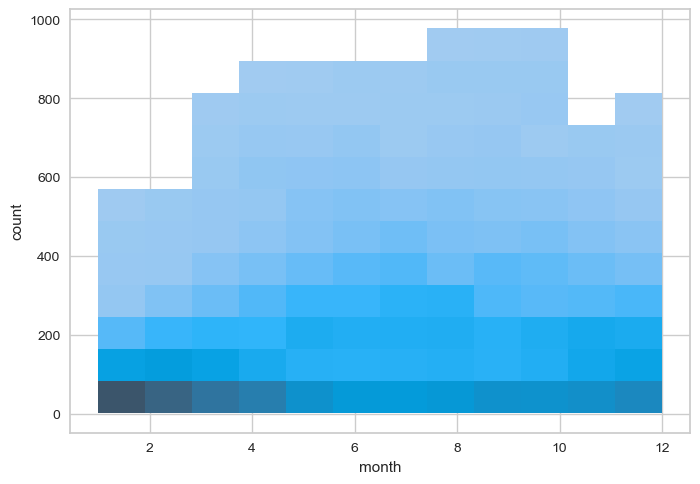

In [25]:
sns.histplot(data=clean_train_df,x="month", y="count", bins=12)
plt.show()

- 7 ~ 9월달 사용자가 늘어나는구나~

In [26]:
## 일별 평균
clean_train_df.groupby("day").mean(numeric_only=True)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month
day,,,,,,,,,,,
1,2.502609,0.000000,0.666087,1.516522,20.661148,24.271313,65.066087,11.057622,180.333913,2011.500870,6.507826
2,2.506108,0.040140,0.668412,1.474695,20.328272,23.627574,63.010471,12.640643,183.910995,2011.499127,6.523560
3,2.507853,0.041885,0.664921,1.373473,19.913264,23.186152,58.755672,12.345878,194.696335,2011.502618,6.527051
4,2.505226,0.083624,0.623693,1.376307,20.355714,23.866359,61.834495,13.259825,195.705575,2011.501742,6.517422
5,2.502609,0.041739,0.666087,1.389565,20.221913,23.719435,61.784348,13.485597,189.765217,2011.500870,6.509565
6,2.506993,0.000000,0.750000,1.375874,19.614056,23.202841,64.055944,12.411211,189.860140,2011.501748,6.519231
7,2.505226,0.000000,0.749129,1.461672,20.307143,23.879425,63.554007,11.785860,183.773519,2011.501742,6.515679
8,2.496516,0.041812,0.623693,1.487805,20.198571,23.655139,62.756098,13.326335,179.041812,2011.500000,6.487805
9,2.502609,0.000000,0.707826,1.483478,19.818330,23.131774,63.469565,12.374189,187.897391,2011.500870,6.507826


In [27]:
## 시간별 평균
clean_train_df.groupby("time").mean(numeric_only=True)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day
time,,,,,,,,,,,,
00:00:00,2.503297,0.028571,0.681319,1.393407,19.013187,22.462582,68.079121,10.701564,55.138462,2011.501099,6.512088,9.982418
01:00:00,2.502203,0.028634,0.680617,1.431718,18.639648,22.011476,69.581498,10.418839,33.859031,2011.502203,6.506608,9.991189
02:00:00,2.522321,0.029018,0.680804,1.401786,18.455491,21.822623,70.622768,10.125315,22.899554,2011.506696,6.560268,9.973214
03:00:00,2.556582,0.027714,0.667436,1.401848,18.433903,21.814007,72.293303,10.173416,11.757506,2011.512702,6.697460,9.993072
04:00:00,2.545249,0.029412,0.671946,1.427602,18.036290,21.352738,73.640271,10.717605,6.407240,2011.513575,6.638009,9.984163
05:00:00,2.513274,0.028761,0.685841,1.422566,17.610044,20.882002,73.409292,10.062407,19.767699,2011.504425,6.542035,10.002212
06:00:00,2.503297,0.028571,0.681319,1.450549,17.481319,20.722747,73.934066,10.433402,76.259341,2011.501099,6.512088,9.982418
07:00:00,2.503297,0.028571,0.681319,1.479121,17.787692,21.035659,72.292308,10.879283,213.116484,2011.501099,6.512088,9.982418
08:00:00,2.503297,0.028571,0.681319,1.465934,18.461714,21.801637,69.553846,11.787155,362.769231,2011.501099,6.512088,9.982418


In [28]:
## 분기별 평균
clean_train_df.groupby("season").mean(numeric_only=True)

,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day
season,,,,,,,,,,,
1,0.026433,0.680566,1.424423,12.530491,15.228956,56.297841,14.636978,116.343261,2011.507446,2.006329,9.968727
2,0.017563,0.692645,1.422978,22.823483,26.647098,60.852909,13.405607,215.251372,2011.499817,5.001098,10.002195
3,0.035126,0.675082,1.366630,28.789111,32.540783,64.123674,11.508862,234.417124,2011.500549,7.998902,10.001464
4,0.035113,0.675201,1.459766,16.649239,20.059909,66.173738,11.678147,198.988296,2011.500000,11.000366,9.997440


In [29]:
## workingday 평균
clean_train_df.groupby("workingday").mean(numeric_only=True)

,season,holiday,weather,temp,atemp,humidity,windspeed,count,year,month,day
workingday,,,,,,,,,,,
0,2.519862,0.089522,1.387162,19.889839,23.349837,62.192286,12.639916,188.506621,2011.503742,6.538572,9.913932
1,2.500405,0.000000,1.433081,20.390696,23.798153,61.743119,12.874143,193.011873,2011.501079,6.513492,10.029412


- 다중선형회귀를 쓰는게 좋을듯
- 1일부터 19일의 휴일수 그리고 20일부터 월말의 휴일수가 다르지 않나...?

In [30]:
clean_train_df["holiday"].mean()

np.float64(0.02856880396839978)

In [31]:
test_df["holiday"].mean()

np.float64(0.029108270445094717)

- 별로 차이 안나보이긴 하는데 혹시 모르니까 검정통계 해보자

### 트레인과 테스트 세트 간의 holiday 유의미한 차이가 있는지 확인

In [32]:
# ttest_ind 함수를 사용해 t-검정을 수행
group1 = clean_train_df["holiday"]
group2 = test_df["holiday"]
t_statistic, p_value = stats.ttest_ind(group1, group2)

# 검정 결과 출력
print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: -0.2058026201412504
p-value: 0.8369475052925267


- 트레인과 테스트간의 holiday 변수의 유의미한 차이는 없다

In [33]:
# ttest_ind 함수를 사용해 t-검정을 수행
group1 = clean_train_df["humidity"]
group2 = test_df["humidity"]
t_statistic, p_value = stats.ttest_ind(group1, group2)

# 검정 결과 출력
print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: -7.411805083996717
p-value: 1.3031233861627114e-13


- 상대 습도에서 차이가 있다... 예??

In [34]:
# ttest_ind 함수를 사용해 t-검정을 수행
group1 = clean_train_df["atemp"]
group2 = test_df["atemp"]
t_statistic, p_value = stats.ttest_ind(group1, group2)

# 검정 결과 출력
print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: -2.6559309243659697
p-value: 0.007916200143478363


- 체감온도도 차이가 많이 나네...

In [35]:
# ttest_ind 함수를 사용해 t-검정을 수행
group1 = clean_train_df["weather"]
group2 = test_df["weather"]
t_statistic, p_value = stats.ttest_ind(group1, group2)

# 검정 결과 출력
print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: -1.830559597022282
p-value: 0.06718342070708978


- weather 는 비슷까리 하나보다 (독립변수로 써도 될듯)

In [57]:
lr = LinearRegression()
rf = RandomForestClassifier()
et = ExtraTreesClassifier()
gb = GradientBoostingClassifier()
# 선형회귀 평가 함수
def lr_score(x_train, x_test, y_train, y_test, scaled, model = False ):
    # 평가해보자...
    if scaled == "ss":
        # 일단 스탠다드로
        ss = StandardScaler()
        x_train = ss.fit_transform(x_train)
        x_test = ss.transform(x_test)
    elif scaled == "mm":
        mm = MinMaxScaler()
        x_train = mm.fit_transform(x_train)
        x_test = mm.transform(x_test)
    elif scaled == "rb":
        rb = RobustScaler()
        x_train = rb.fit_transform(x_train)
        x_test = rb.transform(x_test)
    else :
        # 스케일안함
        pass
        
    if model == "lr" :
        lr.fit(x_train, y_train)
        train_score = lr.score(x_train, y_train)
        test_score = lr.score(x_test, y_test)
        print("선형회귀")
        print("train 점수는 : ", train_score)
        print("test 점수는 : ", test_score)
        pred = lr.predict(x_test)
        # 거리기반 친구들을 평가할때 잘 쓰 자 나 요
        mae = mean_absolute_error(y_test, pred)
        mse = mean_squared_error(y_test, pred)
        print("mae : ", mae)
        print("mse : ", np.sqrt(mse))

    print("--"*10)
    

### 차이가 너무 심하다 싶음 독립변수는 없애버릴것임

In [91]:
clean_train_df.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'count', 'year', 'month', 'day', 'time'],
      dtype='object')

In [82]:
clean_df = clean_train_df.drop(["humidity","atemp","temp","year","month","day","time"], axis = 1)
clean_df2 = clean_train_df.drop(["year","month","day","time"], axis = 1) # 기본적으로 "year","month","day","time" 이거 없애고 시작


# year 과 month 와 
clean_df3 = clean_train_df
clean_df3[["year","month","day"]] = clean_df3.loc[:,["year","month","day"]].astype(int)
clean_df3 = clean_df3.drop(["humidity","atemp","temp","time","day"], axis = 1)



# baseline

### 독립변수 종속변수

In [59]:
x = clean_df.drop(["count"], axis = 1)
y = clean_df["count"]

x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size = 0.2,
    random_state = 33,
)
# 선형성이 보이는 애들이니까 선형회귀 쓸것임
# 평가하기
lr_score(x_train, x_test, y_train, y_test, "ss","lr")

선형회귀
train 점수는 :  0.060080474173965004
test 점수는 :  0.060953835443995685
mae :  134.6592766697363
mse :  174.25791564483563
--------------------


- 딱히 스케일러 차이 ㄴㄴ

In [64]:
clean_df.head()

,season,holiday,workingday,weather,windspeed,count
0,1,0,0,1,0.0,16
1,1,0,0,1,0.0,40
2,1,0,0,1,0.0,32
3,1,0,0,1,0.0,13
4,1,0,0,1,0.0,1


In [89]:
x = clean_df3.drop(["count"], axis = 1)
y = clean_df3["count"]

x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size = 0.2,
    random_state = 33,
)
# 선형성이 보이는 애들이니까 선형회귀 쓸것임
# 평가하기
lr_score(x_train, x_test, y_train, y_test, "ss","lr")

선형회귀
train 점수는 :  0.13180550628513865
test 점수는 :  0.124232462513726
mae :  128.07540585210992
mse :  168.28424741402551
--------------------
